## Track upwelled water

Are my functions for HCW not working or why can't I find any upwelled water in the no-canyon Astoria, no-canyon Barkley and Barkley cases?

In [4]:
import cmocean as cmo
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import seaborn as sns
import canyon_tools.readout_tools as rout
import canyon_tools.savitzky_golay as sg
import canyon_tools.metrics_tools as mtt 

In [5]:
sns.set_style('dark')

In [6]:
def mask2DCanyon(bathy, sbdepth=-152.5):
    '''Mask out the canyon from the shelf.
    bathy : depths 2D array from the grid file
    sbdepth: shelf depth, always negative float 
    Returns mask'''
    
    bathyMasked = np.ma.masked_less(-bathy, -152.5)
    return(bathyMasked.mask)

def BottomConc(Tr, hfac, ra, bathy, sbdepth=-152.5):
    '''Tr: Tracer field (nt,nz,ny,nx)
       hfac: fraction of open cell at center (nz,ny,nx)
       ra: array of cell horizontal areas (ny,nx)
       bathy : depths 2D array from the grid file (ny,nx)
       sbdepth: shelf break depth (negative value)
       
       RETURNS:
       ConcArea = concentration at cell closest to bottom times its area (nt,ny,nx)
       Conc = cocnetration near bottom (nt,ny,nx)'''
    
    ConcArea = np.empty((360,616))
    Conc = np.empty((360,616))
    ConcFiltered = np.empty((360,616))
    Area = np.empty((360,616))
    BottomInd = np.argmax(hfac[::-1,:,:]>0.0,axis=0) # start looking for first no-land cell from the bottom up.
    BottomInd = np.ones(np.shape(BottomInd))*89 - BottomInd # Get index of unreversed z axis
    
    for j in range(616):
        for i in range(360):
            TrBottom = Tr[BottomInd[i,j],i,j]
            ConcArea[i,j] = TrBottom*ra[i,j]
            Conc[i,j] = TrBottom
            Area[i,j] = ra[i,j]
                    
        # Filter step noise
        ConcFiltered[:,j] = sg.savitzky_golay(Conc[:,j], 7,3) 
                
    maskShelf = mask2DCanyon(bathy, sbdepth)
    maskShelf = np.expand_dims(maskShelf,0) # expand along time dimension
    maskShelf = maskShelf + np.zeros(Conc.shape)
    
    return (ConcArea,
            np.ma.masked_array(ConcFiltered, mask=maskShelf),
            Area,
           )

def BottomAnom(Tr, hfac, ra, bathy, sbdepth=-152.5):
    '''Tr: Tracer field-Tr field no canyon (nt,nz,ny,nx)
       hfac: fraction of open cell at center (nz,ny,nx)
       ra: array of cell horizontal areas (ny,nx)
       bathy : depths 2D array from the grid file (ny,nx)
       sbdepth: shelf break depth (negative value)
       
       RETURNS:
       ConcArea = concentration at cell closest to bottom times its area (nt,ny,nx)
       Conc = cocnetration near bottom (nt,ny,nx)'''
    
    ConcArea = np.empty((360,616))
    Conc = np.empty((360,616))
    ConcFiltered = np.empty((360,616))
    Area = np.empty((360,616))
    BottomInd = np.argmax(hfac[::-1,:,:]>0.0,axis=0) # start looking for first no-land cell from the bottom up.
    BottomInd = np.ones(np.shape(BottomInd))*89 - BottomInd # Get index of unreversed z axis
    
    for j in range(616):
        for i in range(360):
            TrBottom = Tr[BottomInd[i,j],i,j]
            if TrBottom > 0.0:
                ConcArea[i,j] = TrBottom*ra[i,j]
                Conc[i,j] = TrBottom
                Area[i,j] = ra[i,j]
            else:
                ConcArea[i,j] = np.NaN
                Conc[i,j] = np.NaN
                Area[i,j] = np.NaN
                

        # Filter step noise
        ConcFiltered[:,j] = sg.savitzky_golay(Conc[:,j], 7,3) 
                
    maskShelf = mask2DCanyon(bathy, sbdepth)
    maskShelf = np.expand_dims(maskShelf,0) # expand along time dimension
    maskShelf = maskShelf + np.zeros(Conc.shape)
    
    return (ConcArea,
            np.ma.masked_array(ConcFiltered, mask=maskShelf),
            Area,
           )

def PlotPool(ax,ConcFilt,xslice,yslice,colmap, cmin=-1, cmax=1):
    
    BAC = ConcFilt[yslice,xslice]
    
    mesh = ax.contourf(X[xslice]/1000,Y[yslice]/1000,BAC,20,
                       vmin=cmin, vmax=cmax, cmap=colmap, 
                      )
    cs = ax.contour(X[xslice]/1000,Y[yslice]/1000,BAC,[0.1,0.2,0.5,0.9,1.0],colors='k')
    plt.clabel(cs)
    #SB = ax.contour(X[xslice]/1000,Y[yslice]/1000,
    #                Depth[yslice,xslice],
    #                [152.5],
    #                colors='0.1',linewidths=[0.75] )
    ax.tick_params(axis='x', pad=1)
    ax.tick_params(axis='y', pad=1)
    ax.set_aspect(1)
    return(mesh)

In [7]:
# Grid, state and tracers datasets of base case
grid_fileC = '/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/gridGlob.nc'
ptracers_fileC = '/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/ptracersGlob.nc'

grid_fileNoCC = '/data/kramosmu/results/TracerExperiments/CNTDIFF/run42/gridGlob.nc'
ptracers_fileNoCC = '/data/kramosmu/results/TracerExperiments/CNTDIFF/run42/ptracersGlob.nc' 

grid_fileA = '/data/kramosmu/results/TracerExperiments/UPW_8TR/01_Ast03/gridGlob.nc'
ptracers_fileA = '/data/kramosmu/results/TracerExperiments/UPW_8TR/01_Ast03/ptracersGlob.nc'

grid_fileNoCA = '/data/kramosmu/results/TracerExperiments/UPW_8TR/02_Ast03_No_Cny/gridGlob.nc'
ptracers_fileNoCA = '/data/kramosmu/results/TracerExperiments/UPW_8TR/02_Ast03_No_Cny/ptracersGlob.nc' 

grid_fileB = '/data/kramosmu/results/TracerExperiments/UPW_8TR/03_Bar03/gridGlob.nc'
ptracers_fileB = '/data/kramosmu/results/TracerExperiments/UPW_8TR/03_Bar03/ptracersGlob.nc'

grid_fileNoCB = '/data/kramosmu/results/TracerExperiments/UPW_8TR/04_Bar03_No_Cny/gridGlob.nc'
ptracers_fileNoCB = '/data/kramosmu/results/TracerExperiments/UPW_8TR/04_Bar03_No_Cny/ptracersGlob.nc' 

In [19]:
with Dataset(grid_fileC, 'r') as nbl:
    ZC = nbl.variables['RC'][:]
    YC = nbl.variables['Y'][:]
    hFacC = nbl.variables['HFacC'][:]
    DepthC = nbl.variables['Depth'][:]
    hfac = np.ma.masked_values(hFacC, 0)
    maskCC = np.ma.getmask(hfac)

with Dataset(grid_fileB, 'r') as nbl:
    ZB = nbl.variables['RC'][:]
    YB = nbl.variables['Y'][:]
    hFacB = nbl.variables['HFacC'][:]
    DepthB = nbl.variables['Depth'][:]
    hfac = np.ma.masked_values(hFacB, 0)
    maskCB = np.ma.getmask(hfac)

with Dataset(grid_fileA, 'r') as nbl:
    ZA = nbl.variables['RC'][:]
    YA = nbl.variables['Y'][:]
    hFacCA = nbl.variables['HFacC'][:]
    DepthA = nbl.variables['Depth'][:]
    hfac = np.ma.masked_values(hFacCA, 0)
    maskCA = np.ma.getmask(hfac)


### Comparison of all canyons at days 0, 1, 4, 6, 8

#### Canyon axis

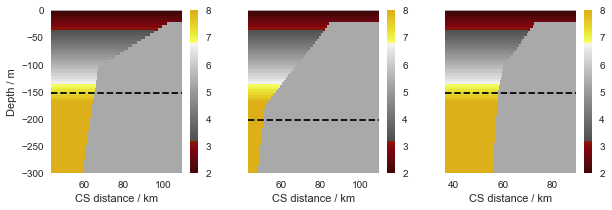

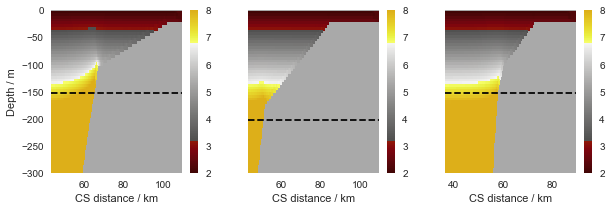

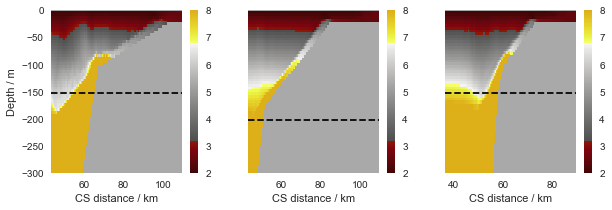

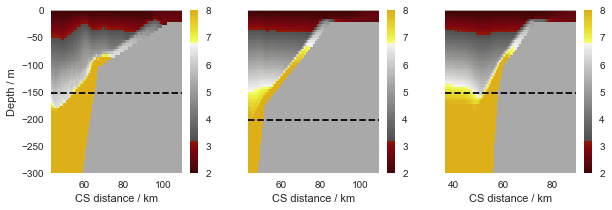

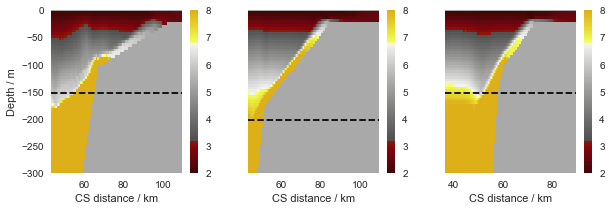

In [33]:
times = [0,2,8,12,16]
zslice = slice(0,70)
xslice = 180 # canyon axis
yslice = slice(120,360)


for tt in times:
    
    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,3), sharey=True)
    for ax in [ax1,ax2,ax3]:
        ax.set_facecolor("darkgrey")
        ax.set_xlabel('CS distance / km')

    with Dataset(ptracers_fileA, 'r') as ptr:
        TrA = np.ma.masked_array(ptr.variables['Tr01'][tt,zslice,yslice,xslice], mask=maskCA[zslice,yslice,xslice])
    with Dataset(ptracers_fileB, 'r') as ptr:
        TrB = np.ma.masked_array(ptr.variables['Tr01'][tt,zslice,yslice,xslice], mask=maskCB[zslice,yslice,xslice])
    with Dataset(ptracers_fileC, 'r') as ptr:
        TrC = np.ma.masked_array(ptr.variables['Tr1'][tt,zslice,yslice,xslice], mask=maskCC[zslice,yslice,xslice])
        
    pc1 = ax1.pcolor(YA[yslice]/1000,ZA[zslice],TrA, cmap=cmo.cm.oxy, vmin=2, vmax=8)
    plt.colorbar(pc1, ax=ax1)
    pc2 = ax2.pcolor(YB[yslice]/1000,ZB[zslice],TrB, cmap=cmo.cm.oxy, vmin=2, vmax=8)
    plt.colorbar(pc2, ax=ax2)
    pc3 = ax3.pcolor(YC[yslice]/1000,ZC[zslice],TrC, cmap=cmo.cm.oxy, vmin=2, vmax=8)
    plt.colorbar(pc3, ax=ax3)
     
    ax1.axhline(ZA[30], linestyle='--', color='k')
    ax2.axhline(ZB[40], linestyle='--', color='k')
    ax3.axhline(ZC[30], linestyle='--', color='k')
    
    ax1.set_ylabel('Depth / m')
    ax1.set_ylim(-300,0)
    ax2.set_ylim(-300,0)
    ax3.set_ylim(-300,0)
    

#### Upstream shelf

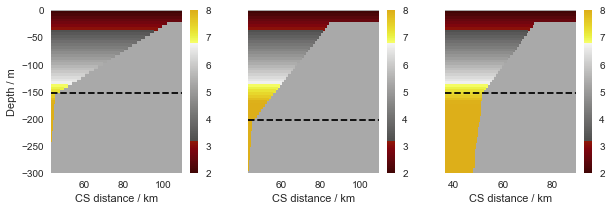

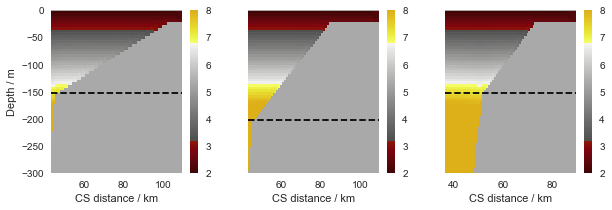

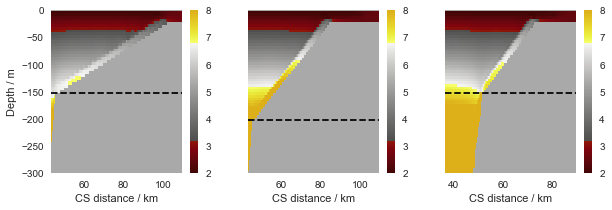

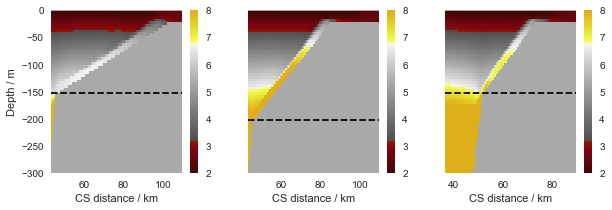

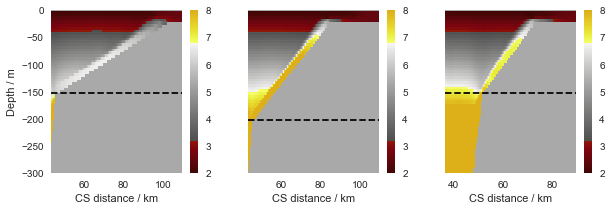

In [35]:
times = [0,2,8,12,16]
zslice = slice(0,70)
xslice = 100 # canyon axis
yslice = slice(120,360)


for tt in times:
    
    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,3), sharey=True)
    for ax in [ax1,ax2,ax3]:
        ax.set_facecolor("darkgrey")
        ax.set_xlabel('CS distance / km')

    with Dataset(ptracers_fileA, 'r') as ptr:
        TrA = np.ma.masked_array(ptr.variables['Tr01'][tt,zslice,yslice,xslice], mask=maskCA[zslice,yslice,xslice])
    with Dataset(ptracers_fileB, 'r') as ptr:
        TrB = np.ma.masked_array(ptr.variables['Tr01'][tt,zslice,yslice,xslice], mask=maskCB[zslice,yslice,xslice])
    with Dataset(ptracers_fileC, 'r') as ptr:
        TrC = np.ma.masked_array(ptr.variables['Tr1'][tt,zslice,yslice,xslice], mask=maskCC[zslice,yslice,xslice])
        
    pc1 = ax1.pcolor(YA[yslice]/1000,ZA[zslice],TrA, cmap=cmo.cm.oxy, vmin=2, vmax=8)
    plt.colorbar(pc1, ax=ax1)
    pc2 = ax2.pcolor(YB[yslice]/1000,ZB[zslice],TrB, cmap=cmo.cm.oxy, vmin=2, vmax=8)
    plt.colorbar(pc2, ax=ax2)
    pc3 = ax3.pcolor(YC[yslice]/1000,ZC[zslice],TrC, cmap=cmo.cm.oxy, vmin=2, vmax=8)
    plt.colorbar(pc3, ax=ax3)
     
    ax1.axhline(ZA[30], linestyle='--', color='k')
    ax2.axhline(ZB[40], linestyle='--', color='k')
    ax3.axhline(ZC[30], linestyle='--', color='k')
    
    ax1.set_ylabel('Depth / m')
    ax1.set_ylim(-300,0)
    ax2.set_ylim(-300,0)
    ax3.set_ylim(-300,0)
    